In [138]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [139]:
intrusion_data = pd.read_csv("cybersecurity_intrusion_data.csv")

In [140]:
intrusion_data.head()

,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0


In [141]:
missed_values = intrusion_data.isnull().sum()
print(missed_values)

session_id                0
network_packet_size       0
protocol_type             0
login_attempts            0
session_duration          0
encryption_used        1966
ip_reputation_score       0
failed_logins             0
browser_type              0
unusual_time_access       0
attack_detected           0
dtype: int64


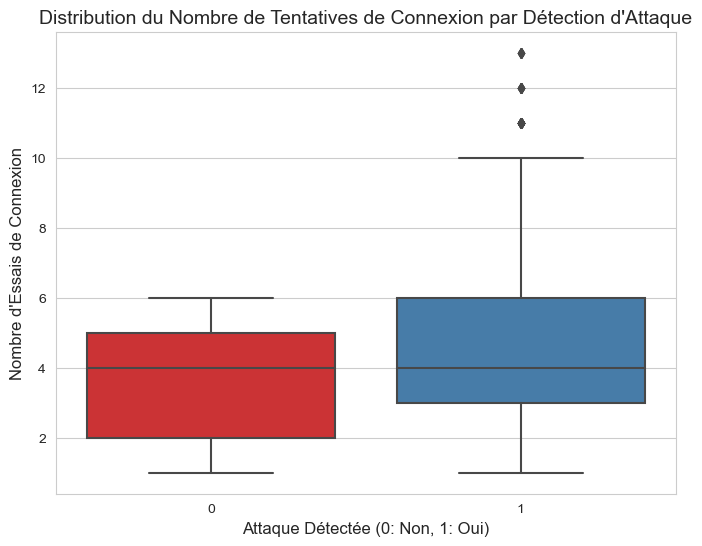

In [142]:
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))

sns.boxplot(
    x='attack_detected', 
    y='login_attempts', 
    data=intrusion_data, 
    palette='Set1'
)
# Customize labels and title
plt.title("Distribution du Nombre de Tentatives de Connexion par Détection d'Attaque", fontsize=14)
plt.xlabel("Attaque Détectée (0: Non, 1: Oui)", fontsize=12)
plt.ylabel("Nombre d'Essais de Connexion", fontsize=12)
plt.show()

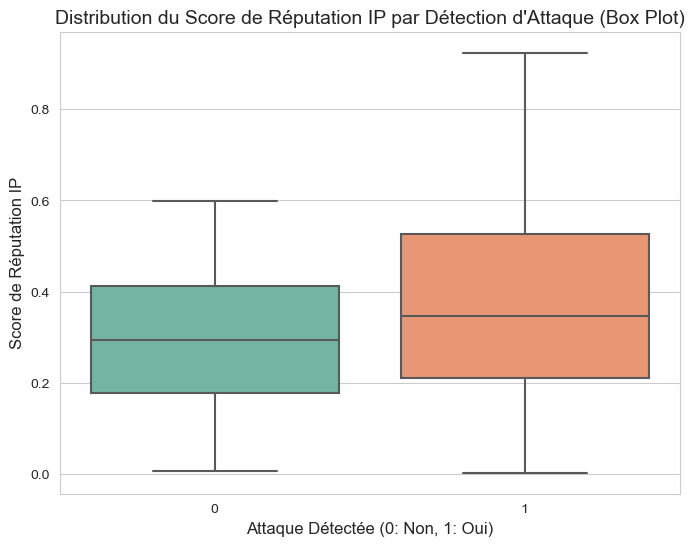

In [143]:
# Set up the plot style
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))

# Créer le Diagramme en Boîte à Moustaches (Box Plot)
# C'est une alternative courante au Violin Plot pour comparer les distributions
sns.boxplot(
    x='attack_detected', 
    y='ip_reputation_score', 
    data=intrusion_data, 
    palette='Set2'
)

# Customize labels and title
plt.title("Distribution du Score de Réputation IP par Détection d'Attaque (Box Plot)", fontsize=14)
plt.xlabel("Attaque Détectée (0: Non, 1: Oui)", fontsize=12)
plt.ylabel("Score de Réputation IP", fontsize=12)
plt.show()

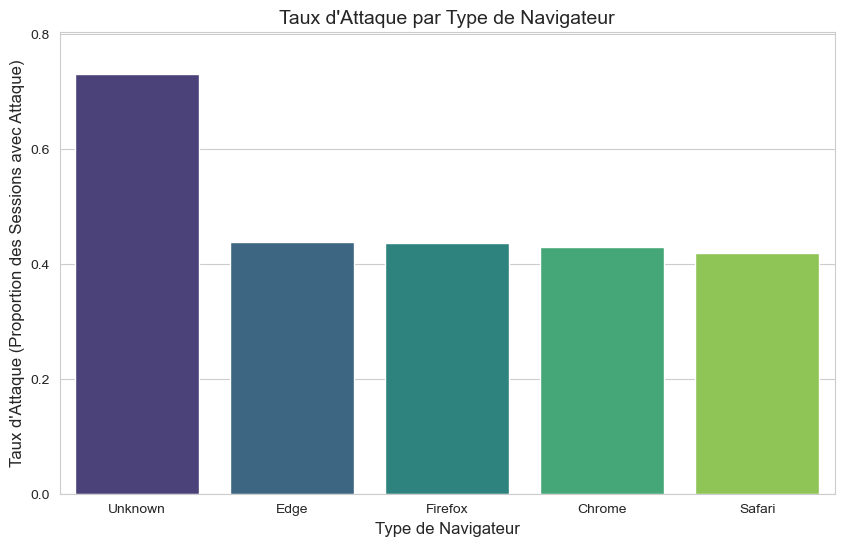

In [144]:
attack_rate_by_browser = intrusion_data.groupby('browser_type')['attack_detected'].mean().reset_index()
attack_rate_by_browser.columns = ['browser_type', 'attack_rate']

# Trier les résultats pour une meilleure visualisation
attack_rate_by_browser = attack_rate_by_browser.sort_values(by='attack_rate', ascending=False)

# 2. Configurer et créer la figure
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# 3. Créer le Diagramme à Barres
sns.barplot(
    x='browser_type', 
    y='attack_rate', 
    data=attack_rate_by_browser, 
    palette='viridis' 
)

# 4. Ajouter les titres et étiquettes
plt.title("Taux d'Attaque par Type de Navigateur", fontsize=14)
plt.xlabel("Type de Navigateur", fontsize=12)
plt.ylabel("Taux d'Attaque (Proportion des Sessions avec Attaque)", fontsize=12)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) # Définir des marques d'axe claires
plt.ylim(0, attack_rate_by_browser['attack_rate'].max() * 1.1) # Ajuster la limite y
plt.show()

c:\Users\julie\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


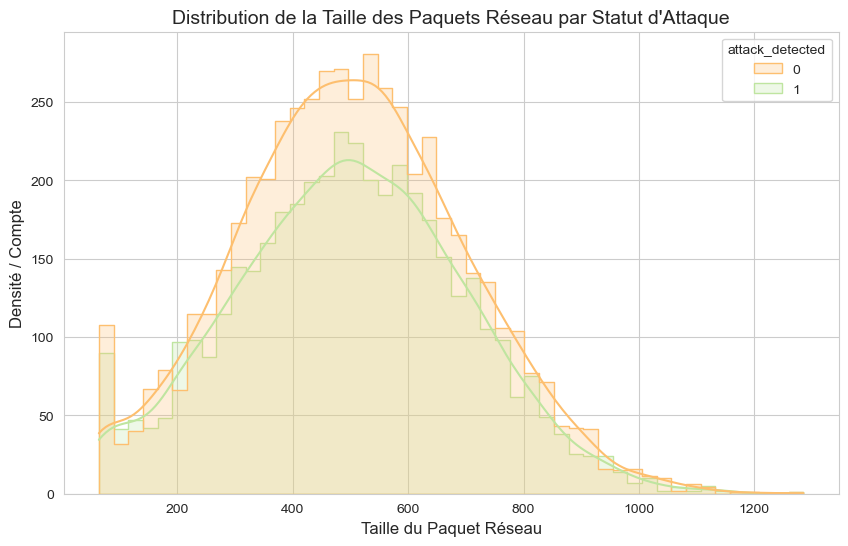

In [145]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Créer l'Histogramme Superposé avec KDE
# 'hue' sépare par classe, 'kde=True' ajoute la courbe de densité
sns.histplot(
    data=intrusion_data, 
    x='network_packet_size', 
    hue='attack_detected', 
    kde=True, 
    palette='Spectral',
    element='step' # Utilise des marches pour les histogrammes superposés
)

# Customize labels and title
plt.title("Distribution de la Taille des Paquets Réseau par Statut d'Attaque", fontsize=14)
plt.xlabel("Taille du Paquet Réseau", fontsize=12)
plt.ylabel("Densité / Compte", fontsize=12)
plt.show()

In [146]:
for col in intrusion_data.columns:
    if intrusion_data[col].dtype == 'object':
        intrusion_data[col].fillna(intrusion_data[col].mode()[0], inplace=True)
    else:
        intrusion_data[col].fillna(intrusion_data[col].mean(), inplace=True)

In [147]:
label_encoders = {}
for col in intrusion_data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    intrusion_data[col] = le.fit_transform(intrusion_data[col])
    label_encoders[col] = le

intrusion_data.drop_duplicates(inplace=True)

In [148]:
X = intrusion_data.drop(columns=['attack_detected'])
X=X.drop(columns=['session_id'])

y = intrusion_data['attack_detected']

In [149]:
correlation_matrix = intrusion_data.corr()


correlations = correlation_matrix['attack_detected'].drop('attack_detected')

#Trier par valeur absolue pour voir les plus fortes corrélations
correlations_sorted = correlations.abs().sort_values(ascending=False)

# Afficher les corrélations triées (en reprenant les valeurs non-absolues pour voir la direction)
print("--- Corrélation de chaque variable avec 'attack_detected'")
print(correlations.reindex(correlations_sorted.index).to_markdown(numalign="left", stralign="left"))

--- Corrélation de chaque variable avec 'attack_detected'
|                     | attack_detected   |
|:--------------------|:------------------|
| failed_logins       | 0.363726          |
| login_attempts      | 0.27732           |
| ip_reputation_score | 0.21154           |
| browser_type        | 0.0841672         |
| session_duration    | 0.0416019         |
| protocol_type       | 0.01389           |
| unusual_time_access | 0.00865152        |
| encryption_used     | 0.0083064         |
| network_packet_size | -0.00679795       |
| session_id          | -0.00247341       |


In [150]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [151]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [152]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraînement

rf_model.fit(X_train, y_train)
# 4. PRÉDICTION ET ÉVALUATION 

# Prédictions sur l'ensemble de test
y_pred_rf = rf_model.predict(X_test)

# Calcul des métriques
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf, digits=4)

print("-" * 50)
print(f"Accuracy du modèle Random Forest : {accuracy_rf:.4f}")
print("\nRapport de Classification :\n", report_rf)
print("-" * 50)

--------------------------------------------------
Accuracy du modèle Random Forest : 0.8836

Rapport de Classification :
               precision    recall  f1-score   support

           0     0.8287    0.9953    0.9044      1055
           1     0.9922    0.7456    0.8514       853

    accuracy                         0.8836      1908
   macro avg     0.9105    0.8704    0.8779      1908
weighted avg     0.9018    0.8836    0.8807      1908

--------------------------------------------------


In [153]:
"""from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, None], # None = pas de limite de profondeur
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}

grid_search = GridSearchCV(
    estimator = rf_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,    
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train,y_train)"""


"from sklearn.model_selection import GridSearchCV\n\nparam_grid = {'n_estimators': [100, 300, 500],\n    'max_depth': [10, 20, None], # None = pas de limite de profondeur\n    'min_samples_split': [2, 5],\n    'min_samples_leaf': [1, 2],\n    'max_features': ['sqrt']\n}\n\ngrid_search = GridSearchCV(\n    estimator = rf_model,\n    param_grid=param_grid,\n    scoring='accuracy',\n    cv=5,    \n    verbose=1,\n    n_jobs=-1\n)\n\ngrid_search.fit(X_train,y_train)"

In [154]:
"""best_parametre = grid_search.best_params_
print(best_parametre)
print(grid_search.best_score_)"""

'best_parametre = grid_search.best_params_\nprint(best_parametre)\nprint(grid_search.best_score_)'

PARTIE AVEC FEATURE 


In [155]:
# Taux d'échec de connexion (failure_rate)
intrusion_data['failure_rate'] = np.where(
    intrusion_data['login_attempts'] > 0,
    intrusion_data['failed_logins'] / intrusion_data['login_attempts'],
    0
)

# Durée par tentative (duration_per_attempt)
intrusion_data['duration_per_attempt'] = np.where(
    intrusion_data['login_attempts'] > 0,
    intrusion_data['session_duration'] / intrusion_data['login_attempts'],
    0
)

In [156]:
X = intrusion_data.drop(columns=['attack_detected'])
X=X.drop(columns=['session_id'])

y = intrusion_data['attack_detected']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [157]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraînement

rf_model.fit(X_train, y_train)
# 4. PRÉDICTION ET ÉVALUATION 

# Prédictions sur l'ensemble de test
y_pred_rf = rf_model.predict(X_test)

# Calcul des métriques
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf, digits=4)

print("-" * 50)
print(f"Accuracy du modèle Random Forest : {accuracy_rf:.4f}")
print("\nRapport de Classification :\n", report_rf)
print("-" * 50)

--------------------------------------------------
Accuracy du modèle Random Forest : 0.8847

Rapport de Classification :
               precision    recall  f1-score   support

           0     0.8295    0.9962    0.9053      1055
           1     0.9938    0.7468    0.8527       853

    accuracy                         0.8847      1908
   macro avg     0.9116    0.8715    0.8790      1908
weighted avg     0.9029    0.8847    0.8818      1908

--------------------------------------------------


In [158]:
correlation_matrix = intrusion_data.corr()


correlations = correlation_matrix['attack_detected'].drop('attack_detected')

#Trier par valeur absolue pour voir les plus fortes corrélations
correlations_sorted = correlations.abs().sort_values(ascending=False)

# Afficher les corrélations triées (en reprenant les valeurs non-absolues pour voir la direction)
print("--- Corrélation de chaque variable avec 'attack_detected'")
print(correlations.reindex(correlations_sorted.index).to_markdown(numalign="left", stralign="left"))

--- Corrélation de chaque variable avec 'attack_detected'
|                      | attack_detected   |
|:---------------------|:------------------|
| failed_logins        | 0.363726          |
| login_attempts       | 0.27732           |
| ip_reputation_score  | 0.21154           |
| failure_rate         | 0.159811          |
| browser_type         | 0.0841672         |
| session_duration     | 0.0416019         |
| duration_per_attempt | -0.0399736        |
| protocol_type        | 0.01389           |
| unusual_time_access  | 0.00865152        |
| encryption_used      | 0.0083064         |
| network_packet_size  | -0.00679795       |
| session_id           | -0.00247341       |


AUTRE FEATURE

In [159]:
bins = [0.0, 0.2, 0.5, np.inf]
labels = ['High_Risk', 'Medium_Risk', 'Low_Risk']
intrusion_data['ip_risk_level'] = pd.cut(
    intrusion_data['ip_reputation_score'], 
    bins=bins, 
    labels=labels, 
    right=False, 
    include_lowest=True
)

# --- 2. Création de la Feature d'Interaction (high_risk_combo) ---
condition = (intrusion_data['browser_type'] == 'Unknown') & (intrusion_data['ip_reputation_score'] < 0.2)
intrusion_data['high_risk_combo'] = np.where(condition, 1, 0)

In [160]:
X = intrusion_data.drop(['attack_detected', 'session_id'], axis=1)
y = intrusion_data['attack_detected']

categorical_cols_to_encode = [
    'protocol_type', 
    'encryption_used', 
    'browser_type', 
    'ip_risk_level' 
]

X_encoded = pd.get_dummies(X, columns=categorical_cols_to_encode, drop_first=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# --- 3. NOUVELLE SÉPARATION TRAIN/TEST ---

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, 
    y, 
    test_size=0.2,     
    random_state=42,   
    stratify=y         
)



In [161]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraînement

rf_model.fit(X_train, y_train)
# 4. PRÉDICTION ET ÉVALUATION 

# Prédictions sur l'ensemble de test
y_pred_rf = rf_model.predict(X_test)

# Calcul des métriques
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf, digits=4)

print("-" * 50)
print(f"Accuracy du modèle Random Forest : {accuracy_rf:.4f}")
print("\nRapport de Classification :\n", report_rf)
print("-" * 50)

--------------------------------------------------
Accuracy du modèle Random Forest : 0.8831

Rapport de Classification :
               precision    recall  f1-score   support

           0     0.8291    0.9934    0.9038      1055
           1     0.9891    0.7468    0.8510       853

    accuracy                         0.8831      1908
   macro avg     0.9091    0.8701    0.8774      1908
weighted avg     0.9007    0.8831    0.8802      1908

--------------------------------------------------


In [162]:
label_encoders = {}
for col in intrusion_data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    intrusion_data[col] = le.fit_transform(intrusion_data[col])
    label_encoders[col] = le

intrusion_data.drop_duplicates(inplace=True)

In [164]:
data_corr_encoded = pd.concat([X_encoded, y], axis=1)

# 2. Calculer la matrice de corrélation
correlation_matrix = data_corr_encoded.corr()

# 3. Extraire la corrélation de toutes les features avec 'attack_detected'
correlations = correlation_matrix['attack_detected'].drop('attack_detected')

# 4. Trier par valeur absolue pour voir les plus fortes corrélations
correlations_sorted = correlations.abs().sort_values(ascending=False)

# Afficher les corrélations triées (avec les nouvelles features)
print("--- Corrélation de chaque variable avec 'attack_detected' (avec les nouvelles features) ---")
print(correlations.reindex(correlations_sorted.index).to_markdown(numalign="left", stralign="left"))

--- Corrélation de chaque variable avec 'attack_detected' (avec les nouvelles features) ---
|                           | attack_detected   |
|:--------------------------|:------------------|
| failed_logins             | 0.363726          |
| login_attempts            | 0.27732           |
| ip_risk_level_Low_Risk    | 0.211829          |
| ip_reputation_score       | 0.21154           |
| failure_rate              | 0.159811          |
| browser_type_4            | 0.13463           |
| ip_risk_level_Medium_Risk | -0.0929637        |
| session_duration          | 0.0416019         |
| duration_per_attempt      | -0.0399736        |
| browser_type_3            | -0.0132889        |
| browser_type_2            | -0.0105559        |
| unusual_time_access       | 0.00865152        |
| encryption_used_1         | 0.0083064         |
| browser_type_1            | -0.00805707       |
| protocol_type_2           | 0.00790291        |
| network_packet_size       | -0.00679795       |
| protoc